# #############################


# Customer Segmentation, broad approach
    1. Our data set will be the output from Lifetime Value run; that run introduced customr lifespan, and customer lifetime value columns that we might use for segmentation. Plus, this ensures that both our lifetime value and customer segmentation models learned from the same set of customer ids.
    2. We will use pipelines to numericize our features (numeric features, ordinal categorical features, nominal categorical features)
    3. Use K-Means model for clustering
    4. Evaluate clustering performance using metrics
    5. Visualize our clusters using PCA


# SECTION: Library Installations and GPU checks

In [1]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU (Metal) is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
Num GPUs Available: 1


In [2]:
import tensorflow as tf
import time

# Create a large random tensor
tensor_a = tf.random.normal([1000, 1000])
tensor_b = tf.random.normal([1000, 1000])

# Perform matrix multiplication on GPU
start_time = time.time()
result = tf.matmul(tensor_a, tensor_b)
end_time = time.time()

print("Time taken for matrix multiplication:", end_time - start_time, "seconds")

Time taken for matrix multiplication: 0.005357027053833008 seconds


2025-04-07 15:27:13.239446: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-07 15:27:13.239595: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-07 15:27:13.239609: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-07 15:27:13.239919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-07 15:27:13.239949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# SECTION: Imports and more Libary Installs

In [3]:
#! brew install cmake

In [4]:
#! pip install tensorflow-datasets

In [5]:
# ! pip install scikit-learn

In [6]:
# ! pip install shap


In [7]:
# ! pip install keras-tuner

In [162]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow_datasets as tfds
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

from scipy import stats
from scipy.stats import boxcox

import keras
import keras_tuner as kt

from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

##especially for clustering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE

# shap
#import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
#from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(42)
%matplotlib inline

# FILL IN CODE HERE #
RANDOM_SAMPLES_VAL = 500000 #To make computing on local machine, colab palatable, we will use a random sample for the exercise  
RANDOM_STATE = 42

# SECTION: Our helper and utility functions

In [5]:
#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

# SECTION: Data Load

In [14]:
#retail_cls.csv is output from lifetime value run. That run added two calculated columns to our data set: customr lifespan, and customer lifetime value
retail_cust_seg_df =pd.read_csv('retail_clv.csv')

In [15]:
retail_cust_seg_df.shape

(500000, 80)

In [16]:
retail_cust_seg_df.head()

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase,customer_lifespan,customer_lifetime_value
0,459789,44,Male,High,Yes,6,No,Divorced,3,High School,...,Winter,No,13,Yes,High,53,Low,102,4.8,216758.440672
1,967130,51,Other,High,Yes,9,No,Married,2,High School,...,Spring,No,9,Yes,Medium,40,High,154,5.4,10765.518761
2,79799,40,Female,Low,Yes,9,Yes,Single,2,Bachelor's,...,Spring,No,0,Yes,High,5,Low,101,5.4,160387.665202
3,705284,52,Other,Low,Yes,6,Yes,Single,4,High School,...,Winter,Yes,8,Yes,Low,80,High,185,4.8,303726.766564
4,905737,63,Other,Low,No,9,Yes,Divorced,0,Master's,...,Summer,Yes,9,Yes,Medium,96,Low,45,5.4,13730.511388


In [17]:
summarize_dataframe(retail_cust_seg_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,customer_id,int64,0,500000,500000
1,age,int64,0,500000,62
2,gender,object,0,500000,3
3,income_bracket,object,0,500000,3
4,loyalty_program,object,0,500000,2
...,...,...,...,...,...
75,website_visits,int64,0,500000,100
76,social_media_engagement,object,0,500000,3
77,days_since_last_purchase,int64,0,500000,365
78,customer_lifespan,float64,0,500000,10


In [18]:
retail_cust_seg_df.columns

Index(['customer_id', 'age', 'gender', 'income_bracket', 'loyalty_program',
       'membership_years', 'churned', 'marital_status', 'number_of_children',
       'education_level', 'occupation', 'transaction_id', 'transaction_date',
       'product_id', 'product_category', 'quantity', 'unit_price',
       'discount_applied', 'payment_method', 'store_location',
       'transaction_hour', 'day_of_week', 'week_of_year', 'month_of_year',
       'avg_purchase_value', 'purchase_frequency', 'last_purchase_date',
       'avg_discount_used', 'preferred_store', 'online_purchases',
       'in_store_purchases', 'avg_items_per_transaction',
       'avg_transaction_value', 'total_returned_items', 'total_returned_value',
       'total_sales', 'total_transactions', 'total_items_purchased',
       'total_discounts_received', 'avg_spent_per_category',
       'max_single_purchase_value', 'min_single_purchase_value',
       'product_name', 'product_brand', 'product_rating',
       'product_review_count', '

In [24]:
# period of data set
retail_cust_seg_df['transaction_date'] = pd.to_datetime(retail_cust_seg_df['transaction_date'])
EARLIEST_DATE = retail_cust_seg_df['transaction_date'].min()
LATEST_DATE   = retail_cust_seg_df['transaction_date'].max()
print(f"Data set spans from {EARLIEST_DATE} TO {LATEST_DATE}")
DATE_OF_ANALYSIS = LATEST_DATE + + pd.Timedelta(days=1) # Our date of analysis is one day after the last day in the data set. Busy day!
print(f"Our date of analysis is: { DATE_OF_ANALYSIS}")

Data set spans from 2020-01-01 00:00:59 TO 2021-12-31 23:56:51
Our date of analysis is: 2022-01-01 23:56:51


In [26]:
#calculate date of last purchase for a customer
jj = retail_cust_seg_df.groupby('customer_id')['transaction_date'].max()

In [38]:
print(f" {type(DATE_OF_ANALYSIS) = }, {type(retail_cust_seg_df['transaction_date']) = }")

 type(DATE_OF_ANALYSIS) = <class 'pandas._libs.tslibs.timestamps.Timestamp'>, type(retail_cust_seg_df['transaction_date']) = <class 'pandas.core.series.Series'>


In [40]:
#Add recency days for each customer, = date of analysis - customer's last transaction date
retail_cust_seg_df['recency'] = (DATE_OF_ANALYSIS - retail_cust_seg_df['transaction_date']).dt.days

In [41]:
#now for frequency score per customer, = number of purchases made by a customer in a period of the data set
#frequency for a customer = number of transaction ids for the customer
jj = retail_cust_seg_df.groupby('customer_id')['transaction_id'].count()

In [43]:
jj.max()

1

In [44]:
retail_cust_seg_df['customer_id'].nunique()

500000

# 
    using transaction id counts for purchase frequency leads to meaningless results, this is because the data set seems to be heavily denormalized. 0.5M rows in data set = 0.5M unique customer ids.
    so, we will use the purchase_frequency column for frequency

In [45]:
retail_cust_seg_df['frequency'] = retail_cust_seg_df['purchase_frequency'].copy()

In [46]:
#similar reasons to assign monetary value to a customer
retail_cust_seg_df['monetary'] = retail_cust_seg_df['total_sales'].copy()

In [47]:
retail_cust_seg_df.columns

Index(['customer_id', 'age', 'gender', 'income_bracket', 'loyalty_program',
       'membership_years', 'churned', 'marital_status', 'number_of_children',
       'education_level', 'occupation', 'transaction_id', 'transaction_date',
       'product_id', 'product_category', 'quantity', 'unit_price',
       'discount_applied', 'payment_method', 'store_location',
       'transaction_hour', 'day_of_week', 'week_of_year', 'month_of_year',
       'avg_purchase_value', 'purchase_frequency', 'last_purchase_date',
       'avg_discount_used', 'preferred_store', 'online_purchases',
       'in_store_purchases', 'avg_items_per_transaction',
       'avg_transaction_value', 'total_returned_items', 'total_returned_value',
       'total_sales', 'total_transactions', 'total_items_purchased',
       'total_discounts_received', 'avg_spent_per_category',
       'max_single_purchase_value', 'min_single_purchase_value',
       'product_name', 'product_brand', 'product_rating',
       'product_review_count', '

# Feature Selection - I
        Core Customer Metrics
1.          Recency – Days since the last purchase  
2.          Frequency – Total number of purchases  
3.          Monetary – Average or total amount spent  
4.          Customer Lifetime Value – Estimated value of the customer over time  
5.          Customer Lifespan – Duration between first and most recent purchase  
6.          Total Transactions – Total number of transactions (measures engagement level)  

        Loyalty and Commitment Indicators
7.          Loyalty Program – Brand commitment indicator  
        
        Price Sensitivity
8.          Avg Discount Used – Customer’s price sensitivity  
        
        Digital Engagement
9.          App Usage – Level of digital engagement  
        
        Brand Interaction Levels
10.         Social Media Engagement – Brand interaction level  
        
        Economic Status
11.         Income Bracket – Proxy for spending power  
        
        Life Stage Behavior
12.         Age – Life stage & buying patterns  
        
        Promotion Sensitivity
13.         Promotion Effectiveness – Responsiveness to marketing promotions  

        Channel Preferences
14.         Online Purchases – Preference for digital shopping  
15.         In-store Purchases** – Preference for physical retail  

In [48]:
included_features = [
    'recency', 'frequency', 'monetary', 'customer_lifetime_value', 'customer_lifespan', 
    'total_transactions', 'loyalty_program', 'avg_discount_used', 'app_usage', 
    'social_media_engagement', 'income_bracket', 'age', 'promotion_effectiveness', 
    'online_purchases', 'in_store_purchases'
]
retail_cust_seg_df = retail_cust_seg_df[included_features]

In [49]:
retail_cust_seg_df.shape

(500000, 15)

In [ ]:
retail_cust_seg_df

In [52]:
summarize_dataframe(retail_cust_seg_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,recency,int64,0,500000,731
1,frequency,int64,0,500000,4
2,monetary,float64,0,500000,392605
3,customer_lifetime_value,float64,0,500000,500000
4,customer_lifespan,float64,0,500000,10
5,total_transactions,int64,0,500000,99
6,loyalty_program,object,0,500000,2
7,avg_discount_used,float64,0,500000,51
8,app_usage,object,0,500000,3
9,social_media_engagement,object,0,500000,3


In [ ]:
#I. create 3 lists of feature types. Pipeline will have a specific encoder for each of these 3 lists
numeric_features = [
    'recency', 'frequency', 'monetary', 'customer_lifetime_value', 
    'customer_lifespan', 'total_transactions', 'avg_discount_used', 'age', 
    'online_purchases', 'in_store_purchases'
]

ordinal_cat_features = [
    'app_usage', 'social_media_engagement', 'income_bracket', 'promotion_effectiveness'
]

nominal_cat_features = [
    'loyalty_program'
]


In [64]:
for i in (ordinal_cat_features + nominal_cat_features):
    print(i, retail_cust_seg_df[i].unique())

app_usage ['High' 'Medium' 'Low']
social_media_engagement ['Low' 'High' 'Medium']
income_bracket ['High' 'Low' 'Medium']
promotion_effectiveness ['Low' 'High' 'Medium']
loyalty_program ['Yes' 'No']


In [83]:
# specify ordinal categories for encoding
app_usage_order = social_media_engagement_order = income_bracket_order = promotion_effectiveness_order = ['High', 'Medium','Low']
ordinal_categories = [app_usage_order, social_media_engagement_order, income_bracket_order, promotion_effectiveness_order]

# Define transformers for numeric, ordinal, and nominal features
# All features = numeric features + ordinal cat features + nominal features
# Pipieline will apply specified encoder to EACH column in the 3 lists: numeric features, ordinal features, nominal features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ordinal_categories))
])
#Nominal variables that have no order, get one hot encoder, drop = first to drop first hot encoded column
#to reduce collinearity, handle unknown = true to handle encoding issues with encoding test data set
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

#Now define the column by column transformer for the full data set
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_cat_features),
        ('nom', nominal_transformer, nominal_cat_features)
    ]
)

X = retail_cust_seg_df[ numeric_features + ordinal_cat_features + nominal_cat_features]

#split X 60,20,20
X_temp_untransformed, X_test_untransformed = train_test_split(X, test_size=0.2, random_state=RANDOM_STATE)
X_train_untransformed, X_val_untransformed = train_test_split(X_temp_untransformed, test_size=0.25, random_state=RANDOM_STATE)

In [84]:
print("_"*150)
print("SHAPES OF SPLIT DATA SETS")
print("_"*150)
print(f"{ type(X_train_untransformed) = }, { X_train_untransformed.shape = }")
print(f"{ type(X_val_untransformed) = }, { X_val_untransformed.shape = }")
print(f"{ type(X_test_untransformed) = }, { X_test_untransformed.shape = }")
print("_"*150)
print("_"*150)

______________________________________________________________________________________________________________________________________________________
SHAPES OF SPLIT DATA SETS
______________________________________________________________________________________________________________________________________________________
 type(X_train_untransformed) = <class 'pandas.core.frame.DataFrame'>,  X_train_untransformed.shape = (300000, 15)
 type(X_val_untransformed) = <class 'pandas.core.frame.DataFrame'>,  X_val_untransformed.shape = (100000, 15)
 type(X_test_untransformed) = <class 'pandas.core.frame.DataFrame'>,  X_test_untransformed.shape = (100000, 15)
______________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________


In [85]:
# Let's create a clustering pipeline and fit a K-Means of 5 clusters
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clustering', KMeans(n_clusters=5, random_state=RANDOM_STATE))
])

clustering_pipeline.fit(X_train_untransformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['recency', 'frequency',
                                                   'monetary',
                                                   'customer_lifetime_value',
                                                   'customer_lifespan',
                                                   'total_transactions',
                                                   'avg_discount_used', 'age',
                                                   'online_purchases',
                                                   'in_store_purchases']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low']]))]),
                                                  ['app_usage',
                                                   'social_media_engagement',
                                                   'income_bracket',
                                                   'promotion_effectiveness']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['loyalty_program'])])),
                ('clustering', KMeans(n_clusters=5, random_state=42))])

# Note clustering_pipeline fit *internally* transforms X_train (raw) and produces the fitted clusters.

    And thus to get transformed (= std scaled numeric feat + one hot encoded nominal feats + ordinal encoded ordinal feats ) X_train, you have to explicity call clustering_pipeline.named_steps['preprocessor'].transfom on X_train_untransformed

In [88]:
# Lets predict our clusters for training data set

train_labels = clustering_pipeline.named_steps['clustering'].labels_

#you predict labels on transformed data, for X_train this was not an issue
#since when we fitted on X_train_unstranformed, sk learn internally transformed the 
# the raw unstransformed X_train_untransformed.
#To predict cluster labels on val data, first we need to get the transformed version of val
#Then predict on this transformed version

val_transformed = clustering_pipeline.named_steps['preprocessor'].transform(X_val_untransformed)
val_labels = clustering_pipeline.named_steps['clustering'].predict(val_transformed)

In [92]:
print(f" {train_labels.shape = }, { val_labels.shape = }")
print(f"Cluster labels for training set: {train_labels}")
print(f"Cluster predictions for validation set: {val_labels}")

 train_labels.shape = (300000,),  val_labels.shape = (100000,)
Cluster labels for training set: [3 0 4 ... 3 2 1]
Cluster predictions for validation set: [3 2 0 ... 1 3 4]


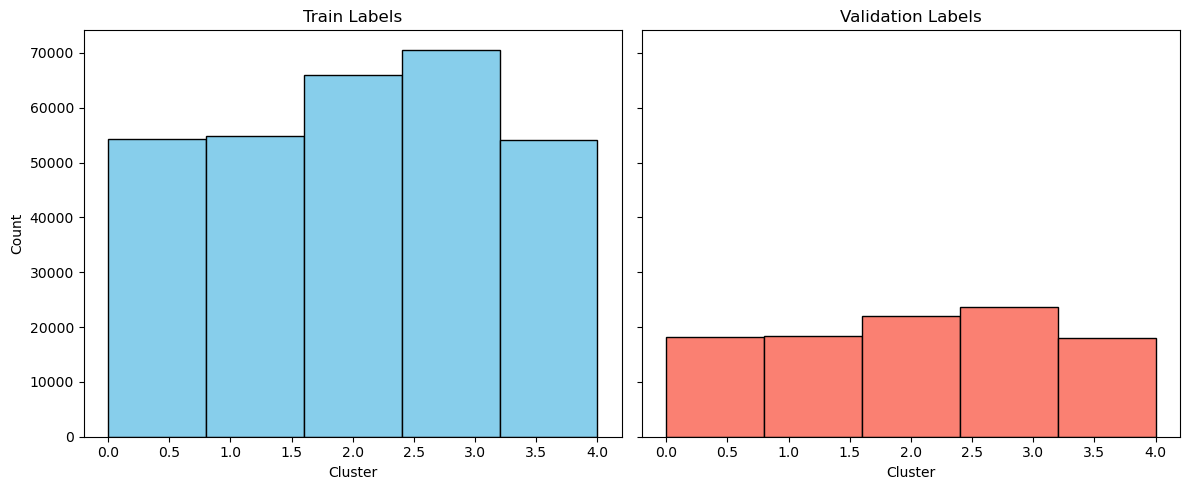

In [ ]:
# Visualize labels
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Training set labels histogram
axs[0].hist(train_labels, bins=len(set(train_labels)), color='skyblue', edgecolor='black')
axs[0].set_title('Training Cluster Labels')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')

# Validation set labels histogram
axs[1].hist(val_labels, bins=len(set(val_labels)), color='salmon', edgecolor='black')
axs[1].set_title('Validation Cluster Labels')
axs[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

# 
    Clustering Evaluation Metrics:
  -     Silhouette Score: Measures how well-separated and well-formed the clusters are. Higher values are better.
  -     Davies-Bouldin Score: Measures the compactness and separation of clusters. Lower values are better.
  -     Inertia: Measures how close the points are to their assigned cluster centroids. Lower values are better.
  

# Approach
    We will use inertia to select the number of clusters (via elbow plot), and use silhouette / Davies-Bouldin to evaluate clustering quality.

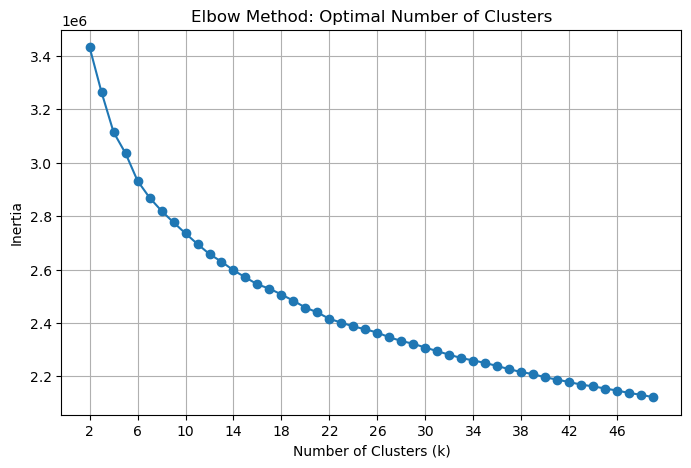

In [103]:
## Use Elbow plot to visualize the baest number of clusters to use
# use inertia as the measurement criteris

# Transform the training data once using your pipeline's preprocessor
X_train_transformed = preprocessor.fit_transform(X_train_untransformed)

# Now run the Elbow method on the transformed data
k_values = range(2, 50)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_train_transformed)
    inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(2, len(k_values), 4))
plt.grid(True)
plt.show()

# Elbow cluster analysis to determine optimal number of clusters
    There is a trade off: we can increase number of clusters to get reduced inertia (better clustering quality), however interpretation 
    for business decisions becomes difficult.

    We note that at 6 cluster, inertia is about 2.94, which is about 38% higher than the lowest inertia (highest accuracy) attained by 50 clusters.

    We accept this accuracy, and will choose 6 as the optimal cluster size.

    Now, let us fit to 6 clusters

In [104]:
clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clustering', KMeans(n_clusters=6, random_state=RANDOM_STATE))
])
clustering_pipeline.fit(X_train_untransformed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['recency', 'frequency',
                                                   'monetary',
                                                   'customer_lifetime_value',
                                                   'customer_lifespan',
                                                   'total_transactions',
                                                   'avg_discount_used', 'age',
                                                   'online_purchases',
                                                   'in_store_purchases']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low']]))]),
                                                  ['app_usage',
                                                   'social_media_engagement',
                                                   'income_bracket',
                                                   'promotion_effectiveness']),
                                                 ('nom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['loyalty_program'])])),
                ('clustering', KMeans(n_clusters=6, random_state=42))])

In [105]:
#get cluster labels
train_labels = clustering_pipeline.predict(X_train_untransformed)
val_labels = clustering_pipeline.predict(X_val_untransformed)

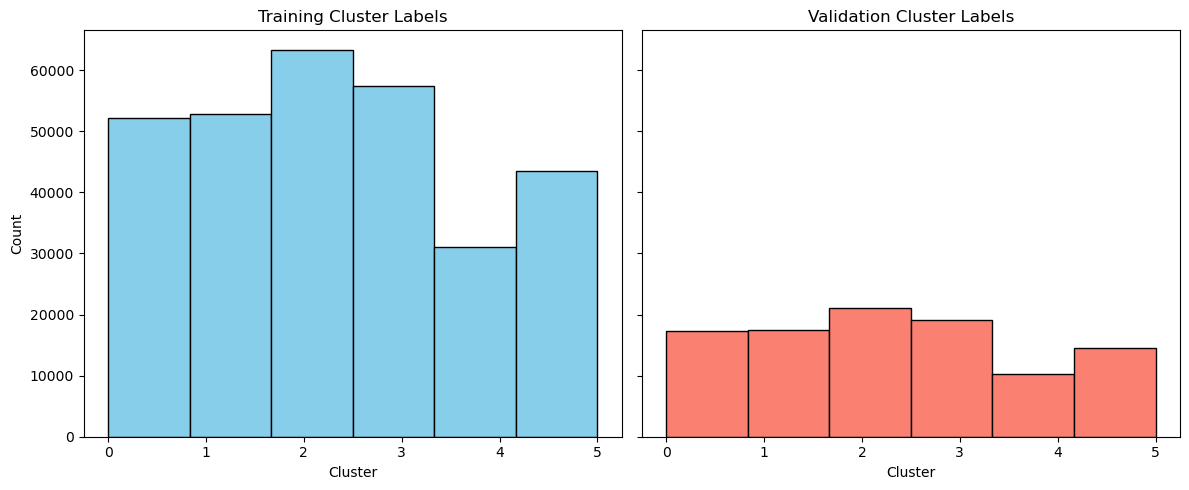

In [106]:
# Visualize labels
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Training set labels histogram
axs[0].hist(train_labels, bins=len(set(train_labels)), color='skyblue', edgecolor='black')
axs[0].set_title('Training Cluster Labels')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Count')

# Validation set labels histogram
axs[1].hist(val_labels, bins=len(set(val_labels)), color='salmon', edgecolor='black')
axs[1].set_title('Validation Cluster Labels')
axs[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

In [109]:
# ============================
# Clustering Evaluation: Evaluate clustering quality using metrics
# ============================
print(f"\nClustering Evaluation Metrics:")

# Inertia (within-cluster sum of squares), already calculated by pipeline
train_inertia = clustering_pipeline.named_steps['clustering'].inertia_
print(f"\nTraining Inertia: {train_inertia:.0f}")

# Now, let us transform the datasets for feeding into metrics evaluation
X_train_transformed = preprocessor.transform(X_train_untransformed)
X_val_transformed = preprocessor.transform(X_val_untransformed)

# Now predict the cluster labels using the clustering step of the pipeline
train_labels = clustering_pipeline.named_steps['clustering'].predict(X_train_transformed)
val_labels = clustering_pipeline.named_steps['clustering'].predict(X_val_transformed)

# Now calculate the silhouette score using the transformed data
train_silhouette_score = silhouette_score(X_train_transformed, train_labels)
val_silhouette_score = silhouette_score(X_val_transformed, val_labels)

print(f"Training Silhouette Score:        {train_silhouette_score:.3f}")
print(f"Validation Silhouette Score:      {val_silhouette_score:.3f}")

train_davies_bouldin_score = davies_bouldin_score(X_train_transformed, train_labels)
val_davies_bouldin_score = davies_bouldin_score(X_val_transformed, val_labels)
print(f"\nTraining Davies-Bouldin Score:    {train_davies_bouldin_score:.3f}")
print(f"Validation Davies-Bouldin Score:  {val_davies_bouldin_score:.3f}")


Clustering Evaluation Metrics:

Training Inertia: 2932241
Training Silhouette Score:        0.063
Validation Silhouette Score:      0.063

Training Davies-Bouldin Score:    2.846
Validation Davies-Bouldin Score:  2.844


In [118]:
# Get the centroids from the KMeans model in the pipeline, 
# cetroids represent the mean values of the features for each cluster.

centroids = clustering_pipeline.named_steps['clustering'].cluster_centers_
print(f"Cluster Centroids:\n{centroids}")

Cluster Centroids:
[[ 1.21262222e-02 -5.66873042e-01 -2.12642104e-02 -3.59520299e-01
   4.76409046e-01 -9.39296757e-01  9.03710023e-03 -1.30804458e-02
   3.33422332e-03  6.99784769e-01  1.00278552e+00  1.00420709e+00
   9.95043704e-01  9.91950821e-01  5.01143022e-01]
 [ 6.46711847e-03 -5.66950731e-01  2.68580631e-03 -3.57405767e-01
   4.81550242e-01  9.61592011e-01 -2.71099158e-02  1.90298045e-02
  -2.42922836e-02  6.48927924e-01  1.00587444e+00  9.86810938e-01
   1.01804021e+00  1.00680298e+00  5.03098293e-01]
 [-7.19454590e-03 -5.70626903e-01 -3.39768329e-04 -3.55145105e-01
   5.07605848e-01 -2.84891750e-02  5.63699683e-03 -1.30463256e-02
   1.09436005e-02 -1.06239494e+00  9.97679082e-01  9.94979238e-01
   9.99889480e-01  9.98436933e-01  4.97150165e-01]
 [-3.63623301e-03 -5.71801878e-01  1.48529044e-02 -5.38759584e-01
  -1.42903008e+00  1.56395159e-03  9.49495754e-03 -4.20030668e-04
   2.80347097e-03 -4.70198401e-02  1.00167492e+00  1.00383837e+00
   9.97662084e-01  9.99214879e-01  4

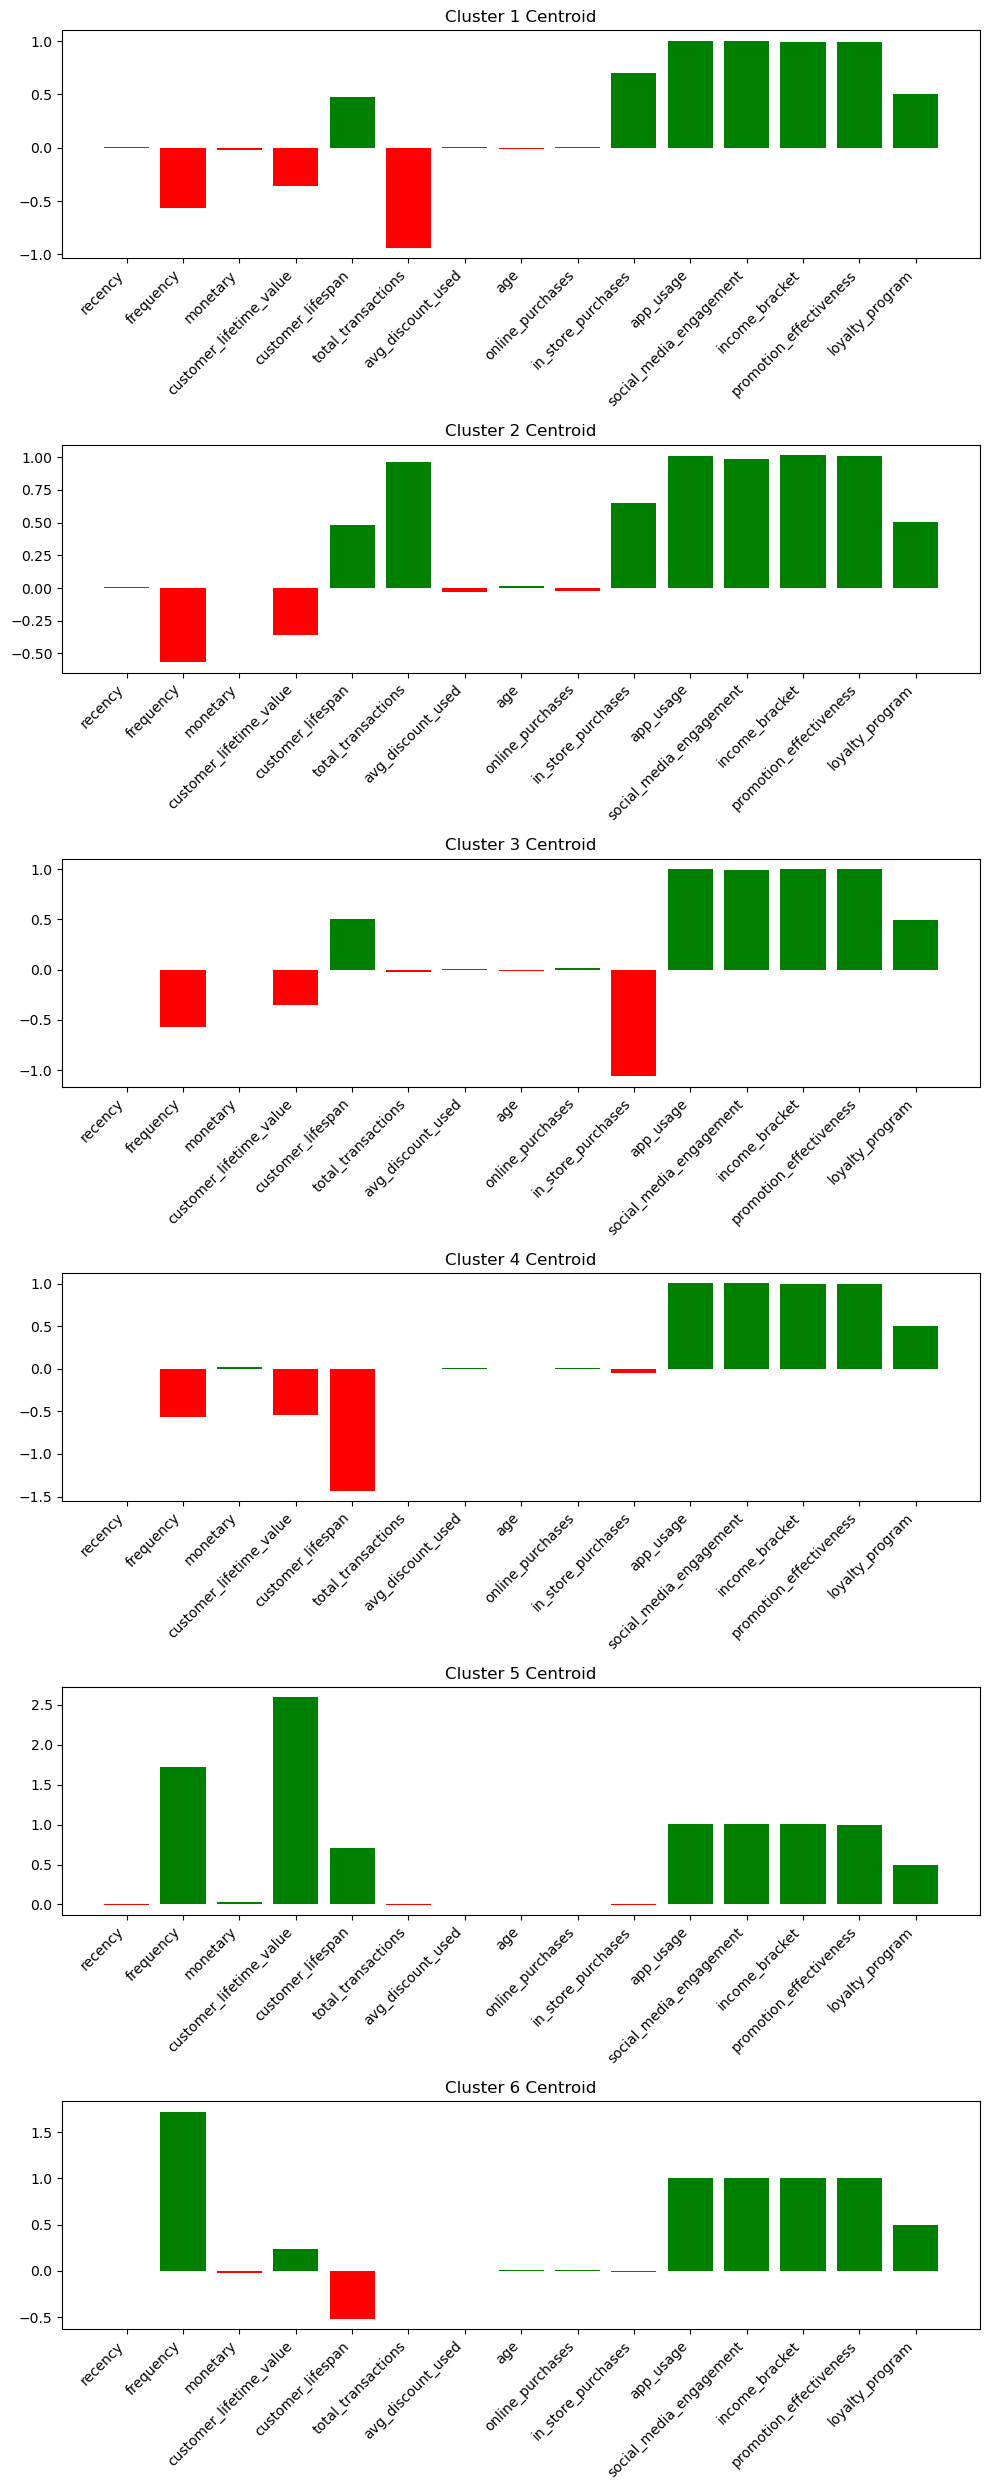

In [123]:
#Lets visualize the centroids to see which features are 'signature or salient' features of each cluster
#this can help us give names to our clustered segments
centroids_df = pd.DataFrame(centroids, columns=numeric_features + ordinal_cat_features + nominal_cat_features)

fig, axes = plt.subplots(6, 1, figsize=(10, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each cluster's centroid in a separate subplot
for i in range(6):  # 6 clusters
    # Color bars: green for positive values, red for negative values
    colors = ['green' if value > 0 else 'red' for value in centroids_df.iloc[i]]

    axes[i].bar(centroids_df.columns, centroids_df.iloc[i], color=colors)
    axes[i].set_title(f'Cluster {i+1} Centroid')
    axes[i].set_xticklabels(centroids_df.columns, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

# Do
    1. Silhoutte visualization
    2. Interpret metrics cluster quality
    3. PCA visualization
    4. tsne visualization
    

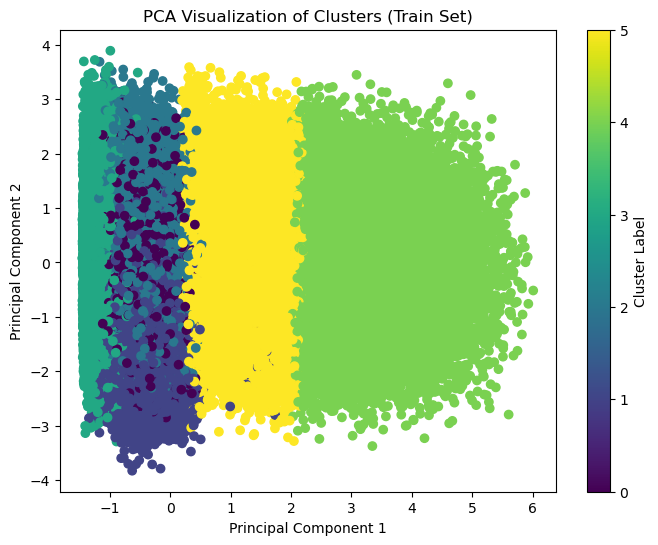

In [124]:
# PCA Cardinality, and visulzaiton of our clusters
# PCA Visualization (Only for Train Set)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(clustering_pipeline.named_steps['preprocessor'].transform(X_train_untransformed))

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_labels, cmap='viridis')
plt.title("PCA Visualization of Clusters (Train Set)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

# PCA visualization comments
    Clusters 4, 5, 3 are rather internally coherent, and cleanly separated. Clusters 0, 1 and 2 not so much. 
    But even though sepraration is not clearly marked, even for clusters 2 and 1, there is rather separate regions.

    We accept these results as good for a first cut. A nest step, would rationalize feature sets, and introduce higher univariate distribution through a more judicious data collection exercise into the clustering exercise.

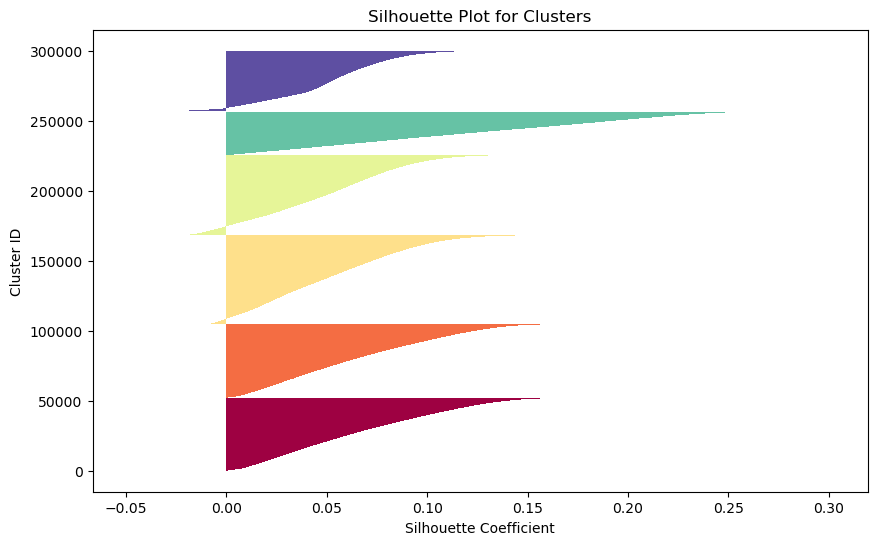

In [126]:
# Silhouette plot

# Get silhouette scores for each sample in the training set
silhouette_vals = silhouette_samples(X_train_transformed, train_labels)


fig, ax = plt.subplots(figsize=(10, 6))
n_clusters = 6
cluster_colors = plt.cm.get_cmap("Spectral", n_clusters) # Create a list of colors corresponding to each cluster
# Loop over all clusters
y_lower = 10
for i in range(n_clusters):
    # Select silhouette scores for the current cluster
    cluster_silhouette_vals = silhouette_vals[train_labels == i]    
    # Sort the silhouette values for the current cluster
    cluster_silhouette_vals.sort()
    # Calculate the upper and lower bounds for the current cluster
    y_upper = y_lower + len(cluster_silhouette_vals)
    # Create the silhouette plot for the current cluster
    ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, edgecolor="none", color=cluster_colors(i))
    # Update the lower bound for the next cluster
    y_lower = y_upper + 10  # 10 for spacing between clusters

# Set plot labels and title
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster ID")
ax.set_title("Silhouette Plot for Clusters")

# Display the plot
plt.show()

    Interpretation of Silhouette scores and coeeficients.

    General guidelines: The silhouette score ranges from -1 to +1:
        +1: The point is very well clustered, far from neighboring clusters.
        0: The point is on or near the decision boundary between clusters.
        -1: The point is likely in the wrong cluster, as it's closer to a neighboring cluster.

    Our clusters' silhouette interpretations:
    Very few points have negative scores, and are far away from -1, indicating that very few points are misclassified (are in the wrong cluster)
    But most silhouette scores are between 0 and 0.15 indicating that most of the points are closer to the decision boundary.

    Similar to PCA analysis findings, as we include features in the data set (and in our clustering) that have good univariate variation (e.g. are not close to uniformly distributed), qualit of clustering should improve. 

    Also, selecting grid searched K-Means, and perhaps even a higher number of clusters (from 6) should improve silhoutte-based performance and our overall clustyer quality.

In [127]:
# Lets do inference
# Transform the test data using the same preprocessor
X_test_transformed = preprocessor.transform(X_test_untransformed)

# Predict the cluster labels for the test data using the clustering step of the pipeline
test_labels = clustering_pipeline.named_steps['clustering'].predict(X_test_transformed)


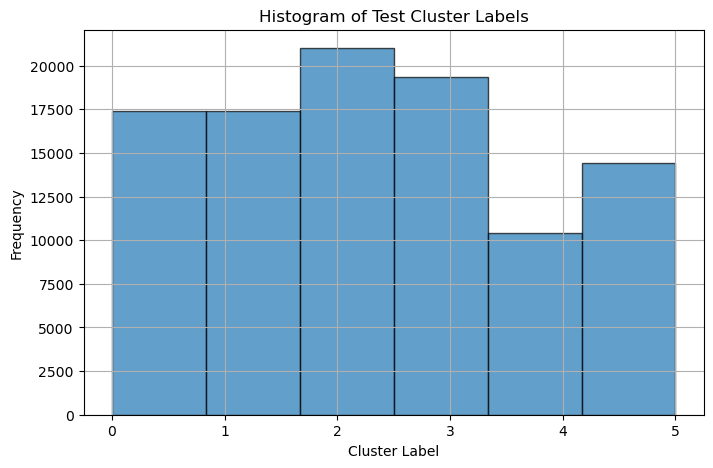

In [131]:
# Plot a histogram of the test labels (predicted cluster labels)
plt.figure(figsize=(8, 5))
plt.hist(test_labels, bins=6, edgecolor='black', alpha=0.7)
plt.title('Histogram of Test Cluster Labels')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.xticks(range(0, len(set(test_labels))))
plt.grid(True)
plt.show()

In [132]:
train_labels.shape
train_labels

(300000,)

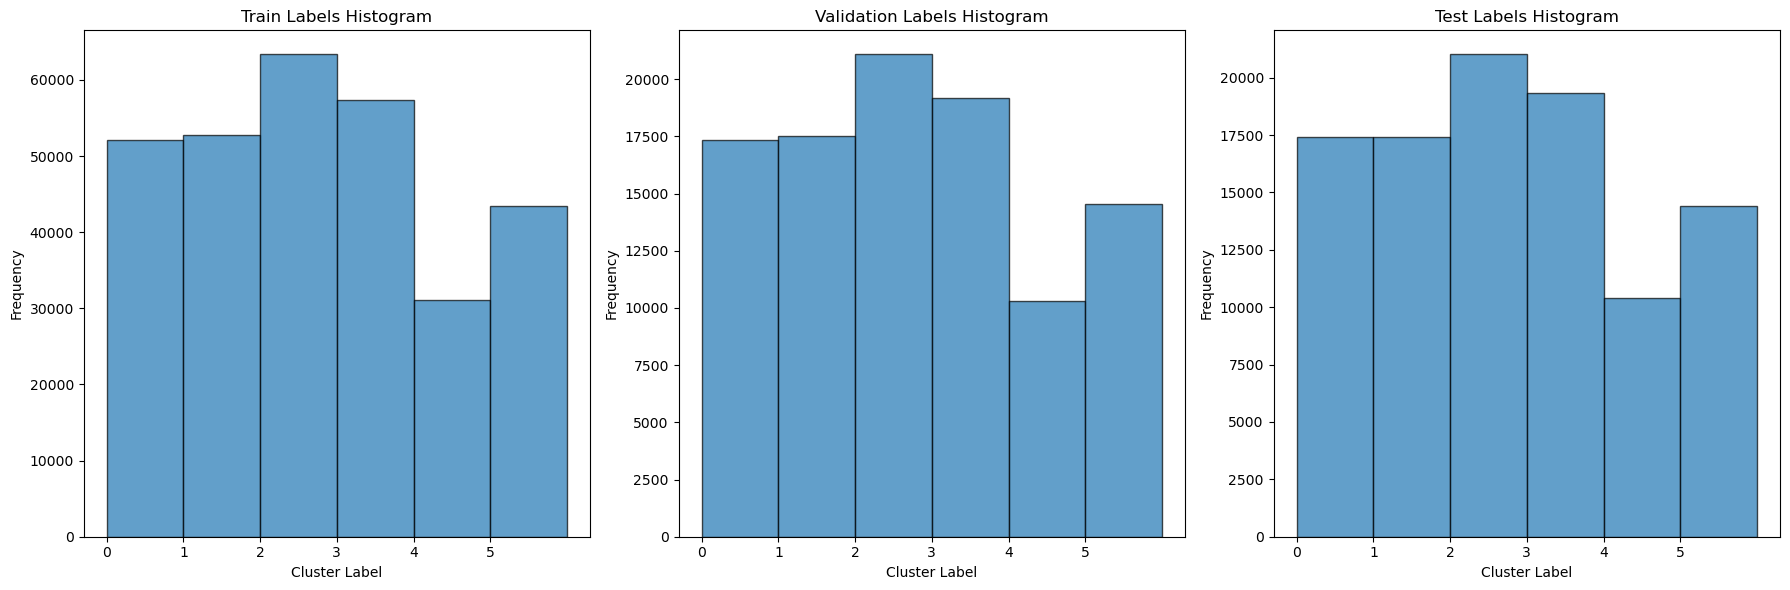

In [133]:
ig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

axes[0].hist(train_labels, bins=range(0, len(set(train_labels)) + 1), edgecolor='black', alpha=0.7)
axes[0].set_title('Train Labels Histogram')
axes[0].set_xlabel('Cluster Label')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(0, len(set(train_labels))))


axes[1].hist(val_labels, bins=range(0, len(set(val_labels)) + 1), edgecolor='black', alpha=0.7)
axes[1].set_title('Validation Labels Histogram')
axes[1].set_xlabel('Cluster Label')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(range(0, len(set(val_labels))))


axes[2].hist(test_labels, bins=range(0, len(set(test_labels)) + 1), edgecolor='black', alpha=0.7)
axes[2].set_title('Test Labels Histogram')
axes[2].set_xlabel('Cluster Label')
axes[2].set_ylabel('Frequency')
axes[2].set_xticks(range(0, len(set(test_labels))))


plt.tight_layout()
plt.show()

#
    The cluster distribution of the three data sets is similar, indicative perhaps of the simulated data. A real world data set can be expected to show higher variation across distributions.

#
    Lets now save our cluster labeled data set

In [156]:
X_combined = pd.concat([X_train_untransformed, X_val_untransformed, X_test_untransformed], ignore_index=True)

In [157]:
print(f" {train_labels.shape = }, {val_labels.shape =}, {test_labels.shape =}")

 train_labels.shape = (300000,), val_labels.shape =(100000,), test_labels.shape =(100000,)


In [158]:
labels_combined = np.concatenate([train_labels, val_labels, test_labels])

In [159]:
X_combined['cluster_labels'] = labels_combined

In [160]:
X_combined.columns

Index(['recency', 'frequency', 'monetary', 'customer_lifetime_value',
       'customer_lifespan', 'total_transactions', 'avg_discount_used', 'age',
       'online_purchases', 'in_store_purchases', 'app_usage',
       'social_media_engagement', 'income_bracket', 'promotion_effectiveness',
       'loyalty_program', 'cluster_labels'],
      dtype='object')

In [161]:
X_combined.to_csv("cluster_labeled_retail_clv.csv")

    T-SNE plot
    # Alternate to PCA, T-SNE Plot: T-SNE plot reduces a high dimensional space to lower dimensions, similar to PCA, like 2 dimensions
    and can be used to view the quality of clustering. Specifically, the plot can show in the clusters, points that are grouped together in the plot represent samples that are similar to each other based on the original high-dimensional features. Cluster Separation: Well-separated groups of points may indicate distinct clusters in the data.

    #But TSNE can be computationally expensive, and for large data sets may take a long time to converge.

In [ ]:
# Transform the data using the preprocessor to encode categorical variables
X_train_transformed = preprocessor.transform(X_train_untransformed)

# Apply t-SNE to reduce the dimensionality of the transformed data to 2D
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_train_tsne = tsne.fit_transform(X_train_transformed)

# Plot the t-SNE results, coloring by the cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=train_labels, cmap='viridis', s=5)
plt.colorbar(label='Cluster Label')
plt.title('t-SNE Plot for Training Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
